In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Let's say we have two versions of the same advertisement that we want to display to customers.

We have no idea what version of the ad is better so we decide to test it. We show some customers one and others the other.

Below I have a simulated dataset of the test results.

In [3]:
ads = pd.read_csv("advertisement_clicks.csv")
ads.head()

,advertisement_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


An action of "1" means the ad was clicked while "0" means it was not clicked. The rows of the dataset represent the views/impressions of the ad.

Below we will explore various methods for evaluating what ad version is better.

## t-Test

A t-Test compares the means of two groups to see if there is a statistically significant difference between them. I will not go into all the details, caveats, and assumptions of this test, but they are [here](https://en.wikipedia.org/wiki/Student%27s_t-test) if you need to learn more. 

In [10]:
#First, extract an array of the click actions for both groups
a = ads[ads['advertisement_id'] == 'A']['action']
b = ads[ads['advertisement_id'] == 'B']['action']
print('Average number of clicks for ad A {} \nAverage number of clicks for ad B {}'.format(a.mean(), b.mean()))

Average number of clicks for ad A 0.304 
Average number of clicks for ad B 0.372


Ad version B received more clicks on average. We'll do a t-Test below to see if this difference in clicks is in fact legit or just noise.

In [12]:
#Import necessary function
#This function is easy to implement but we will not do that here
from scipy.stats import ttest_ind

ttest_ind(a,b, equal_var = False)

Ttest_indResult(statistic=-3.2211732138019786, pvalue=0.0012972410374001632)

If we are working with a 5% sigificance level, then the p-value suggests that there is indeed a difference in the mean number of clicks for both ads. Ad version B wins here.

## Chi-squared Test

A Chi-squared test is used to test for independence between two groups. Mathematically, 5/10, 50/100, and 500/1000 are the same value. Statiscally, they are **probably** different. 5 out of 10 people clicking on an ad is not the same, statistically, as 500/1000 clicking ([Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) anyone?).

In this case, the Chi-squared test is almost redundant because the data is binary and so the means and click through proportions are the same. We will still go ahead to perform the Chi-squared test to illustrate contingency tables.

In [18]:
#import necessary library
from scipy.stats import chi2_contingency

#define variables for building a chi-sqaure contigency table for both categories

##Ad A
ad_a_clicked = a.sum()
ad_a_notclicked = a.shape[0] - ad_a_clicked

##Ad B
ad_b_clicked = b.sum()
ad_b_notclicked = b.shape[0] - ad_b_clicked

#Define contingency table
table = np.array([[ad_a_clicked, ad_a_notclicked], [ad_b_clicked, ad_b_notclicked]])

In [22]:
pd.DataFrame({'Clicked':table[:,0],'Not Clicked':table[:,1]}, index = ['Ad A', 'Ad B'])

,Clicked,Not Clicked
Ad A,304,696
Ad B,372,628


In [23]:
#chi-square test 
p_value = chi2_contingency(table, correction=False)[1]
'p-value = {}'.format(p_value)

'p-value = 0.0013069502732125406'

The p-value is the same as that from the t-Test we performed above. We come to the same conclusion. Ad B wins.

Let's look at a plot of clicks before we move on to our next strategy.

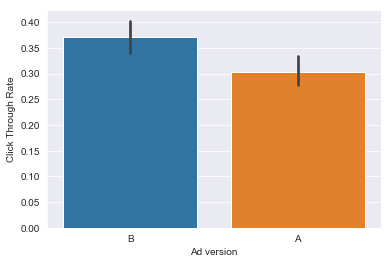

In [32]:
sns.set_style("darkgrid")
sns.barplot(x = 'advertisement_id', y='action',data = ads)
plt.xlabel("Ad version")
plt.ylabel("Click Through Rate")

## Bayesian Method - Thompson Sampling

In simple terms, bayesian inference, derived from bayes theorem, is a method for updating prior belief based on new evidence. If you're into equations, proofs, and definitions, check out the [wikipedia](https://en.wikipedia.org/wiki/Bayesian_inference) page for more info. 

Thompson Sampling is a class of [bandit algorithms](https://en.wikipedia.org/wiki/Multi-armed_bandit) that hinges on bayesian inference. 

With Thompson sampling, we do not know what ad is better but we can construct a dynamic model of reality based on  evidence. Evidence being which ad was clicked at every impression.

Here is how it works, statistically:

 > Construct a beta distribution with alpha and beta equals 1 -  <font color=blue>beta (1,1)</font>. This beta distribution is effectively a uniform distribution (uninformative prior). In english, it means we have zero initial idea of what ad version is better.

 > For each ad version, we will randomly sample this beta distribution and pick the ad with the maximum sample value.

 > Display the ad we picked above to the customer on our site and record whether the ad was clicked or not.

 > Update the beta prior with new information. The uninformative prior now becomes - <font color = blue>beta (1 + number of times this ad was clicked, 1 + number of times this ad was not clicked)</font>.

 > Repeat
 
 After a decent number of rounds, the algorithm will converge on the best ad and show it, almost exclusively, to our customers. 
 
 Again for proofs, definitions, caveats, and more rigorous theory, here is the [wiki](https://en.wikipedia.org/wiki/Thompson_sampling).
 
Our example has a major flaw though. We have pre-generated data even though the algorithm is dynamic and online. The algorithm samples the distributions, picks what ad to display, records clicked/not-clicked data, and updates our priors every time a customer is shown an ad.  This is quite unlike traditional A/B tests, where experiment and analysis are done in separate time intervals.

It will be complicated to demonstrate Thompson sampling in it's real life implementation. For simplicity's sake, we will do it * ex post *. 

In [54]:
#Thompson Sampling algorithm

num_rounds = 2000 #number of rounds
ad_versions = 2
ad_to_display = []
number_of_times_clicked = [0,0]
number_of_times_notclicked = [0,0]

for n in range(0,num_rounds):
    ad_index = 0
    max_random_sample = 0
    ad = ''
    for i in range(0,ad_versions):
        random_beta = np.random.beta(number_of_times_clicked[i] + 1, number_of_times_notclicked[i] + 1 )
        if random_beta > max_random_sample:
            max_random_sample = random_beta
            ad_index = i
    if ad_index == 0:
        ad = 'A'
    else:
        ad = 'B'
        
    ad_to_display.append(ad)
    
    if (ads.iloc[n,0] == ad):
        ad_clicked = ads.iloc[n,1]
        
    else: 
        ad_clicked = 0
        
    if ad_clicked == 1:
        number_of_times_clicked[ad_index] += 1
    else:
        number_of_times_notclicked[ad_index] += 1
    

In [63]:
#convert list of ads_to_display to dictionary

from collections import Counter
ads_displayed_dict = Counter((ad_to_display))

Counter({'A': 433, 'B': 1567})

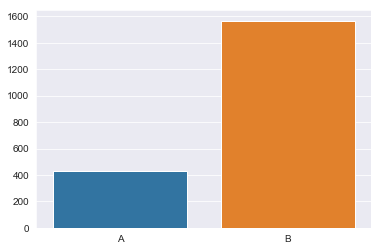

In [69]:
sns.barplot(x = list(ads_displayed_dict.keys()), y = list(ads_displayed_dict.values()))

We see from the plot above that the thompson sampling algorithm learned that ad version B was the better version (getting more clicks) and hence displayed it more than ad version A. 

This result agrees with the results from our frequentist tests, Ad version B is indeed better than A.